In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from data_preprocess import Preprocessor

In [2]:
normal_df = pd.read_csv('data/NormalMotorON.csv')
faulty_df = pd.read_csv('data/FaultyMotorON.csv')
faulty_df_1 = pd.read_csv('data/ImbalancedMotorON.csv')
normal_df_1 = pd.read_csv('data/NormalMotorON_1.csv')
normal_df_2 = pd.read_csv('data/NormalMotorON_2.csv')
faulty_df_2 = pd.read_csv('data/FaultyMotorON_1.csv')
faulty_df_3 = pd.read_csv('data/ImbalancedMotorON_1.csv')

In [24]:
data_df = [normal_df['Volt'], faulty_df['Volt'], faulty_df_1['Volt0'], normal_df_1['Volt0'], normal_df_2['Volt'], faulty_df_2['Volt'], faulty_df_3['Volt']]
types = ['normal', 'faulty', 'faulty', 'normal', 'normal', 'faulty', 'faulty']
sr = [40000, 40000, 30000, 30000, 40000, 40000, 40000]

In [25]:
data_interval = 3
preprocessor = Preprocessor(max_freq=500, kaiser_beta=10)

In [26]:
split_data = []
for i in range(len(data_df)):
    split_data.append(preprocessor.split_in_intervals(data_df[i], sr[i], data_interval))

c:\Users\rarora\DataspellProjects\PredictiveAnalysis\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [27]:
split_fft_amp = []
split_fft_freq = []
for i in range(len(split_data)):
    amp, freq = preprocessor.get_fft_of_split_data(split_data[i], sr[i])
    split_fft_amp.append(amp)
    split_fft_freq.append(freq)

In [28]:
data_full = []
for i in range(len(split_fft_amp)):
    data_full.append(preprocessor.add_type_column(split_fft_amp[i], types[i]))

In [29]:
dataset = np.concatenate(data_full, axis=0)
rand = np.random.default_rng()
rand.shuffle(dataset)
X = dataset[:, :-1]
y = dataset[:, -1]
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(2906, 1501)
(484, 1501)
(485, 1501)


In [39]:
model = keras.Sequential()

In [40]:
input_shape = (X_train.shape[1], 1)
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [41]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1501, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 750, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 750, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 375, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,536,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,544,513 (5.89 MB)

 Trainable params: 1,544,513 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/32


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5813 - loss: 0.6806 - val_accuracy: 0.6206 - val_loss: 0.6474
Epoch 2/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6270 - loss: 0.6140 - val_accuracy: 0.6928 - val_loss: 0.5596
Epoch 3/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7477 - loss: 0.5026 - val_accuracy: 0.7567 - val_loss: 0.4785
Epoch 4/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7918 - loss: 0.4098 - val_accuracy: 0.7567 - val_loss: 0.3861
Epoch 5/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7971 - loss: 0.3706 - val_accuracy: 0.7526 - val_loss: 0.4115
Epoch 6/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7919 - loss: 0.3641 - val_accuracy: 0.8103 - val_loss: 0.3104
Epoch 7/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7953 - loss: 0.3379 - val_accuracy: 0.8103 - val_loss: 0.3064
Epoch 8/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8475 - loss: 0.2795 - val_accuracy: 0.7938 - val_loss: 0.

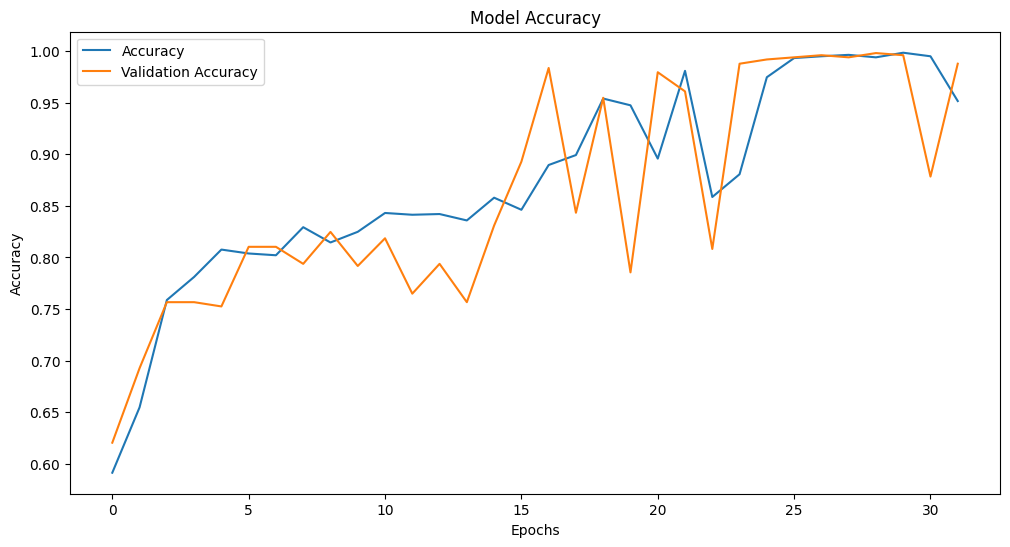

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

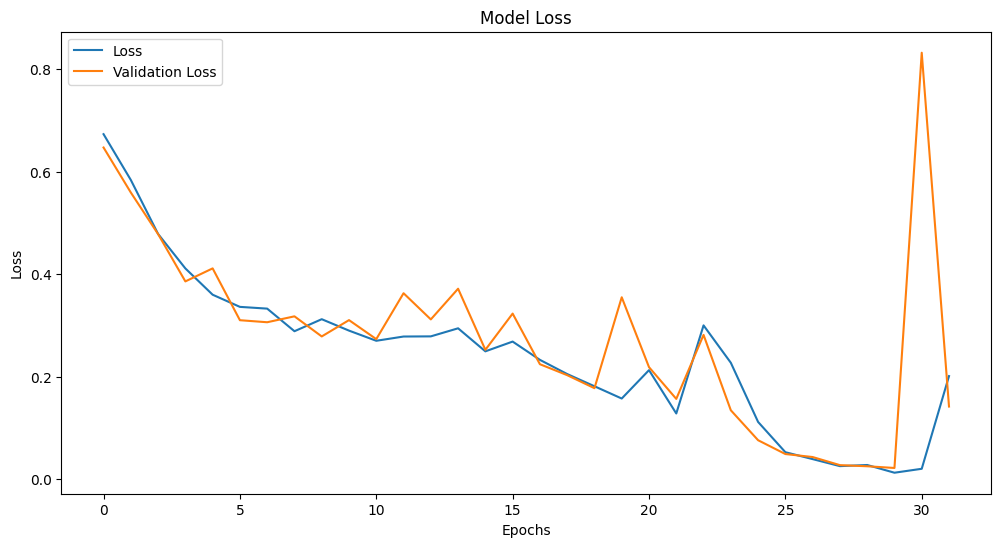

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [46]:
model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9664 - loss: 0.1113


[0.10279274731874466, 0.9793388247489929]

In [48]:
model.save('models/cnn_0.98_500hz_f32_f64_n64_n32_batch32_epochs64_more_data.keras')